In [3]:
import numpy as np
import pandas as pd
import logging
import sys
from graph.graph import AssociatedGraph
from utils.preprocessing import create_graphs, calculate_residue_depth
from config import make_graph_config
import argparse
from os import path
from graph.graph import Graph
from itertools import combinations
from Bio import PDB
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [6]:
def update_pdb_bfactor(input_pdb, output_pdb, merged_df, column="ResidueDepth"):
    """
    Atualiza o B-factor de um arquivo PDB com valores de ResidueDepth ou RSA.

    Parâmetros:
    - input_pdb (str): Caminho do arquivo PDB original.
    - output_pdb (str): Caminho para salvar o PDB modificado.
    - merged_df (pd.DataFrame): DataFrame contendo ResidueNumber, Chain e valores (ResidueDepth ou RSA).
    - column (str): Nome da coluna do DataFrame a ser usada no B-factor ("ResidueDepth" ou "rsa").
    """
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", input_pdb)

    for model in structure:
        for chain in model:
            for residue in chain:
                res_id = residue.get_id()[1]  # Número do resíduo
                chain_id = chain.get_id()  # ID da cadeia

                # Filtrar DataFrame para encontrar a profundidade ou RSA do resíduo
                value = merged_df[(merged_df["ResidueNumber"] == res_id) & (merged_df["Chain"] == chain_id)][column]

                if not value.empty:
                    depth_value = float(value.values[0])  # Extrair valor
                    for atom in residue:
                        atom.set_bfactor(depth_value)  # Atualizar B-factor

    # Salvar novo PDB com os valores alterados
    io = PDB.PDBIO()
    io.set_structure(structure)
    io.save(output_pdb)

    print(f"✅ Arquivo salvo: {output_pdb}")

def generate_ca_combinations(central_node, neighbors, pos=1):
    """
    Gera combinações para calcular ângulos entre carbonos alfa.

    Parâmetros:
    - central_node (tuple): Nó central no formato ('Chain:Residue:ResidueNumber', 'Chain:Residue:ResidueNumber')
    - neighbors (list of tuples): Lista de vizinhos no mesmo formato do nó central

    Retorna:
    - list: Lista de strings formatadas para seleção dos carbonos alfa
    """
    central_residue = central_node[pos-1].split(':')  # Pegamos um dos pares, pois ambos são iguais
    central_chain = central_residue[0]
    central_number = central_residue[2]
    neighbor_combinations = combinations(neighbors, 2)

    selections = [
        f"#1/{central_chain}:{central_number}@CA/{n1[pos-1].split(':')[0]}:{n1[pos-1].split(':')[2]}@CA/{n2[pos-1].split(':')[0]}:{n2[pos-1].split(':')[2]}@CA"
        for n1, n2 in neighbor_combinations
    ]

    return selections

def analysis_rsa_depth(g, residue_depth):
    residue_depth['ResidueNumber'] = residue_depth['ResidueNumber'].astype(int)

    rsa_df = g.graph.graph["dssp_df"]["rsa"].reset_index()
    split_data = rsa_df['node_id'].str.split(':', expand=True)

    # Extrair Chain, ResidueName e ResidueNumber (garantindo conversão segura para números)
    rsa_df['Chain'] = split_data[0]  # Já é string (object)
    rsa_df['ResidueName'] = split_data[1]
    rsa_df['ResidueNumber'] = pd.to_numeric(split_data[2], errors='coerce')  # Converte para float, trata erros

    # Remover linhas com ResidueNumber inválido (NaN)
    rsa_df = rsa_df.dropna(subset=['ResidueNumber'])
    rsa_df['ResidueNumber'] = rsa_df['ResidueNumber'].astype(int)  # Converte para int

    # Selecionar colunas relevantes
    rsa_df = rsa_df[['Chain', 'ResidueNumber', 'rsa']]

    merged_df = residue_depth.merge(
        rsa_df,
        on=['Chain', 'ResidueNumber'],
        how='inner'  # Manter apenas resíduos presentes em ambos
    )

    return merged_df


def min_max_rsa_depth(merged_df):
    # Criar uma nova coluna com a soma de ResidueDepth e rsa
    merged_df['sum'] = merged_df['ResidueDepth'] + merged_df['rsa']

    # Seleção dos 10 resíduos com as menores somas de RSA e Depth
    min_sum_residues = merged_df.nsmallest(10, 'sum')

    # Seleção dos 10 resíduos com as maiores somas de RSA e Depth
    max_sum_residues = merged_df.nlargest(10, 'sum')

    # Seleção dos 10 resíduos com os maiores valores de Depth e menores valores de RSA
    max_depth_min_rsa = merged_df.nlargest(30, 'ResidueDepth').nsmallest(10, 'rsa')

    # Seleção dos 10 resíduos com os maiores valores de RSA e menores valores de Depth
    max_rsa_min_depth = merged_df.nlargest(30, 'rsa').nsmallest(10, 'ResidueDepth')

    return min_sum_residues, max_sum_residues, max_depth_min_rsa, max_rsa_min_depth

def plot_correlation_rsa_depth(merged_df, remove_outliers=False, max_rsa=None, max_depth=None):
    df = merged_df.copy()

    # Filtrar valores máximos, se especificados
    if max_rsa is not None:
        df = df[df['rsa'] <= max_rsa]
    if max_depth is not None:
        df = df[df['ResidueDepth'] <= max_depth]

    # Remover outliers se necessário (usando IQR)
    if remove_outliers:
        Q1 = df[['ResidueDepth', 'rsa']].quantile(0.25)
        Q3 = df[['ResidueDepth', 'rsa']].quantile(0.75)
        IQR = Q3 - Q1

        df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

    # Calcular correlação
    if len(df) > 1:  # Garante que haja dados suficientes para o cálculo
        corr, p_value = pearsonr(df['ResidueDepth'], df['rsa'])
    else:
        corr, p_value = np.nan, np.nan  # Evita erro se não houver dados suficientes

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    sns.regplot(
        x='ResidueDepth',
        y='rsa',
        data=df,
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red'}
    )

    plt.title(f'Correlação ResidueDepth vs RSA (r = {corr:.3f}, p = {p_value:.2e})')
    plt.xlabel('Residue Depth')
    plt.ylabel('RSA')
    plt.grid(True)
    plt.show()

def numbers_to_ranges(numbers):
    if not numbers:
        return []
    numbers_int = [int(num) for num in numbers]
    sorted_numbers = sorted(numbers_int)
    ranges = []
    start = sorted_numbers[0]
    end = start
    for num in sorted_numbers[1:]:
        if num == end + 1:
            end = num
        else:
            ranges.append(f"{start}-{end}" if start != end else str(start))
            start = num
            end = num
    ranges.append(f"{start}-{end}" if start != end else str(start))
    return ranges

def generate_chimerax_selection(df, model_number=1):
    # Agrupa resíduos por cadeia e converte números em intervalos
    grouped = df.groupby('Chain')['ResidueNumber'].apply(list).to_dict()
    chain_parts = []
    for chain in sorted(grouped.keys()):  # Ordena as cadeias alfabeticamente
        numbers = grouped[chain]
        ranges = numbers_to_ranges(numbers)
        if ranges:
            chain_part = f"{chain}:" + ",".join(ranges)
            chain_parts.append(chain_part)
    if not chain_parts:
        return ""
    return f"#{model_number}/" + "/".join(chain_parts)




# SERD 1_4

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


✅ Arquivo salvo: /home/carlos23001/IC/pMHC_graph/pdb_output/mayv_depth_1-4.pdb
✅ Arquivo salvo: /home/carlos23001/IC/pMHC_graph/pdb_output/mayv_rsa.pdb


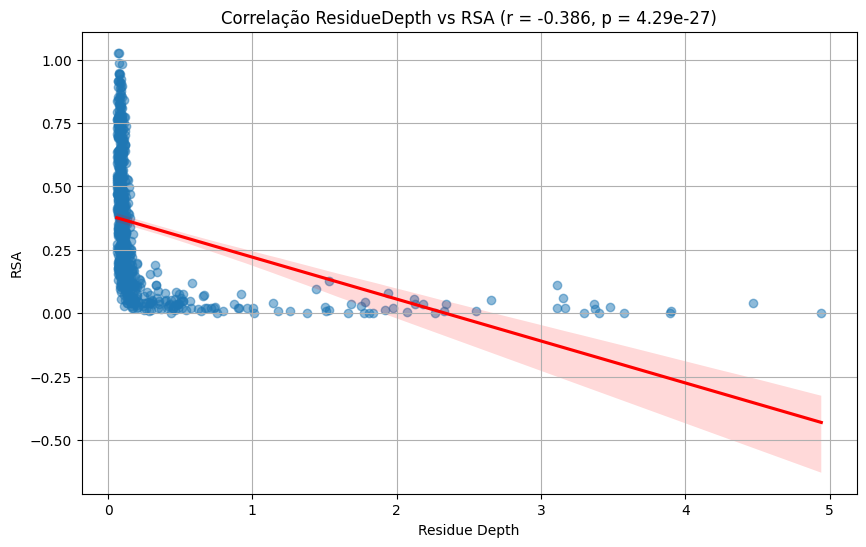

In [7]:
config = make_graph_config(centroid_threshold=10)

config_serd = {
    "probe": 1.4,
    "type": "SES",
}

path_pdb = '/home/carlos23001/IC/pMHC_graph/pdb_input/mayv_ML_7KO8_clean.pdb'

g_test = Graph(config=config, graph_path=path_pdb)
residue_depth_test = calculate_residue_depth(path_pdb, config_serd)
merged_df_test = analysis_rsa_depth(g=g_test, residue_depth=residue_depth_test)
min_sum_residues, max_sum_residues, max_depth_min_rsa, max_rsa_min_depth = min_max_rsa_depth(merged_df=merged_df_test)
sel_min_sum_residues, sel_max_sum_residues, sel_max_depth_min_rsa, sel_max_rsa_min_depth = (generate_chimerax_selection(sel) for sel in [min_sum_residues, max_sum_residues, max_depth_min_rsa, max_rsa_min_depth])

output_depth = '/home/carlos23001/IC/pMHC_graph/pdb_output/mayv_depth_1-4.pdb'
output_rsa = '/home/carlos23001/IC/pMHC_graph/pdb_output/mayv_rsa.pdb'

update_pdb_bfactor(path_pdb, output_depth, merged_df_test, column="ResidueDepth")
update_pdb_bfactor(path_pdb, output_rsa, merged_df_test, column="rsa")

plot_correlation_rsa_depth(merged_df_test, remove_outliers=False)

# SERD 5_0

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


✅ Arquivo salvo: /home/carlos23001/IC/pMHC_graph/pdb_output/mayv_depth_5-0.pdb


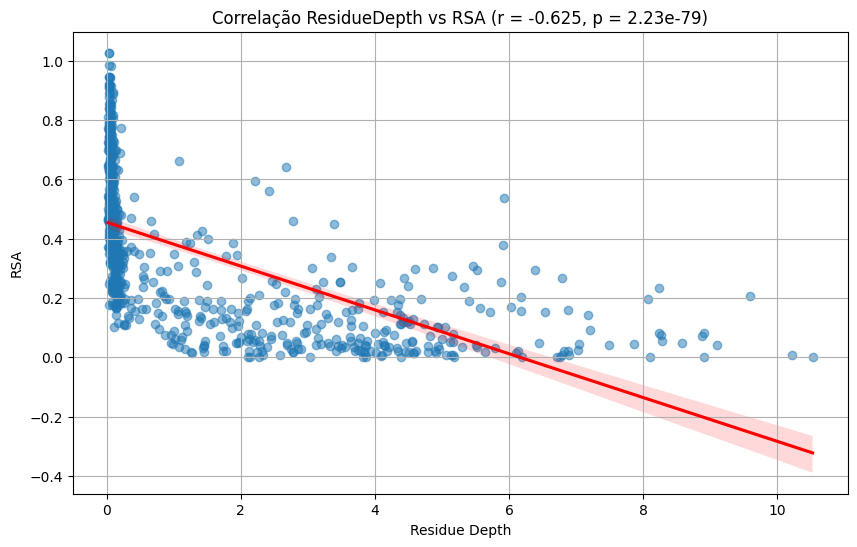

In [8]:
config = make_graph_config(centroid_threshold=10)

config_serd = {
    "probe": 5.0,
    "type": "SES",
}

path_pdb = '/home/carlos23001/IC/pMHC_graph/pdb_input/mayv_ML_7KO8_clean.pdb'

g_test = Graph(config=config, graph_path=path_pdb)
residue_depth_test = calculate_residue_depth(path_pdb, config_serd)
merged_df_test = analysis_rsa_depth(g=g_test, residue_depth=residue_depth_test)
min_sum_residues, max_sum_residues, max_depth_min_rsa, max_rsa_min_depth = min_max_rsa_depth(merged_df=merged_df_test)
sel_min_sum_residues, sel_max_sum_residues, sel_max_depth_min_rsa, sel_max_rsa_min_depth = (generate_chimerax_selection(sel) for sel in [min_sum_residues, max_sum_residues, max_depth_min_rsa, max_rsa_min_depth])

output_depth = '/home/carlos23001/IC/pMHC_graph/pdb_output/mayv_depth_5-0.pdb'

update_pdb_bfactor(path_pdb, output_depth, merged_df_test, column="ResidueDepth")

plot_correlation_rsa_depth(merged_df_test, remove_outliers=False)

# SERD 10-0

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


✅ Arquivo salvo: /home/carlos23001/IC/pMHC_graph/pdb_output/mayv_depth_10-0.pdb


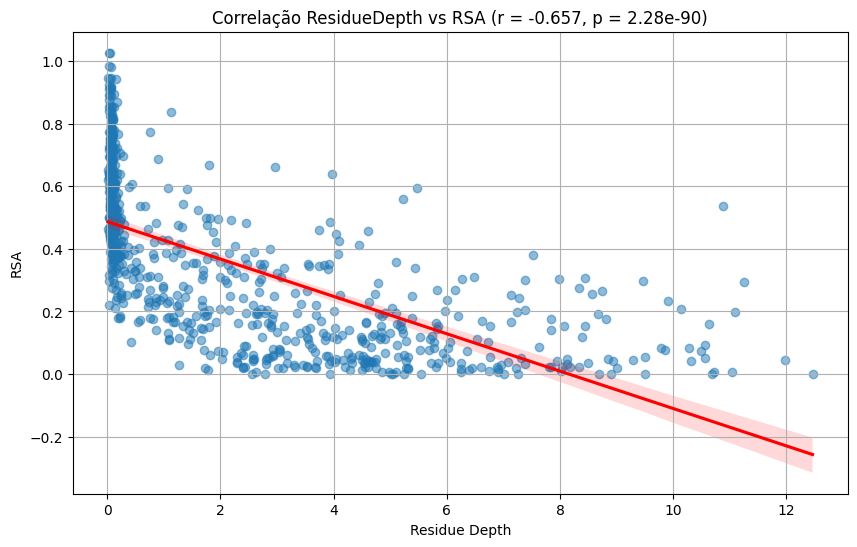

In [9]:
config = make_graph_config(centroid_threshold=10)

config_serd = {
    "probe": 10.0,
    "type": "SES",
}

path_pdb = '/home/carlos23001/IC/pMHC_graph/pdb_input/mayv_ML_7KO8_clean.pdb'

g_test = Graph(config=config, graph_path=path_pdb)
residue_depth_test = calculate_residue_depth(path_pdb, config_serd)
merged_df_test = analysis_rsa_depth(g=g_test, residue_depth=residue_depth_test)
min_sum_residues, max_sum_residues, max_depth_min_rsa, max_rsa_min_depth = min_max_rsa_depth(merged_df=merged_df_test)
sel_min_sum_residues, sel_max_sum_residues, sel_max_depth_min_rsa, sel_max_rsa_min_depth = (generate_chimerax_selection(sel) for sel in [min_sum_residues, max_sum_residues, max_depth_min_rsa, max_rsa_min_depth])

output_depth = '/home/carlos23001/IC/pMHC_graph/pdb_output/mayv_depth_10-0.pdb'

update_pdb_bfactor(path_pdb, output_depth, merged_df_test, column="ResidueDepth")

plot_correlation_rsa_depth(merged_df_test, remove_outliers=False)